## Question 2

In [1]:
from tensorflow import keras 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from ultralytics import YOLO
import cv2
import pickle
from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np
import os

2024-12-04 23:43:07.866875: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import os
import cv2
import torch

# Paths
model_path = './runs/detect/car_detection_20/weights/best.pt'
input_dir = 'car_detection_dataset/testing_images/'
output_dir = 'output_images/'

# Create output directory
os.makedirs(output_dir, exist_ok=True)

# Limit GPU memory usage and clear cache
torch.cuda.set_per_process_memory_fraction(0.8, device=0)
torch.cuda.empty_cache()

# Load YOLO model
model = YOLO(model_path)

def resize_image(image_path, max_size=640):
    """
    Resize the image to a maximum size while maintaining aspect ratio.
    """
    image = cv2.imread(image_path)
    h, w = image.shape[:2]
    scale = max_size / max(h, w)
    new_h, new_w = int(h * scale), int(w * scale)
    resized_image = cv2.resize(image, (new_w, new_h))
    return resized_image, scale

def draw_boxes_and_labels(img, result, scale=1):
    """
    Draw bounding boxes and labels on the image.
    Scale is used to adjust bounding box coordinates if the image was resized.
    """
    for box, conf, cls in zip(result.boxes.xyxy, result.boxes.conf, result.boxes.cls):
        # Scale bounding box coordinates back to the resized image
        x1, y1, x2, y2 = (box.cpu().numpy() * scale).astype(int)
        
        # Draw bounding box
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        # Add label with confidence score
        label = f'Car {conf:.2f}'
        cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    return img

# Process each image in the input directory
input_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

for file_path in input_files:
    print(f"Processing: {file_path}")
    
    # Resize image
    resized_img, scale = resize_image(file_path)
    
    # Get predictions from the model
    results = model(file_path, verbose=False)
    
    # Draw bounding boxes and labels on the resized image
    for r in results:
        resized_img = draw_boxes_and_labels(resized_img, r, scale)
    
    # Save the processed image to the output directory
    output_path = os.path.join(output_dir, os.path.basename(file_path))
    cv2.imwrite(output_path, resized_img)

print("All images processed and saved ")


Processing: car_detection_dataset/testing_images/vid_5_31560.jpg
Processing: car_detection_dataset/testing_images/vid_5_26980.jpg
Processing: car_detection_dataset/testing_images/vid_5_31280.jpg
Processing: car_detection_dataset/testing_images/vid_5_29440.jpg
Processing: car_detection_dataset/testing_images/vid_5_28660.jpg
Processing: car_detection_dataset/testing_images/vid_5_31140.jpg
Processing: car_detection_dataset/testing_images/vid_5_28320.jpg
Processing: car_detection_dataset/testing_images/vid_5_30920.jpg
Processing: car_detection_dataset/testing_images/vid_5_27660.jpg
Processing: car_detection_dataset/testing_images/vid_5_27700.jpg
Processing: car_detection_dataset/testing_images/vid_5_26840.jpg
Processing: car_detection_dataset/testing_images/vid_5_26800.jpg
Processing: car_detection_dataset/testing_images/vid_5_31680.jpg
Processing: car_detection_dataset/testing_images/vid_5_31720.jpg
Processing: car_detection_dataset/testing_images/vid_5_26760.jpg
Processing: car_detection

## Question 3


0: 384x640 1 car, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


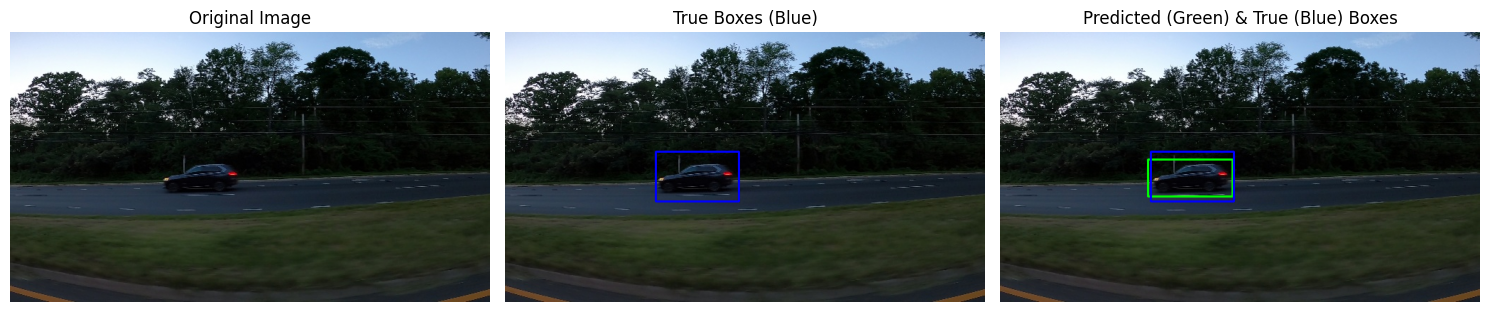


Image: vid_5_27860.jpg
Cars in image: 1
Cars detected: 1

0: 384x640 2 cars, 7.6ms
Speed: 1.3ms preprocess, 7.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


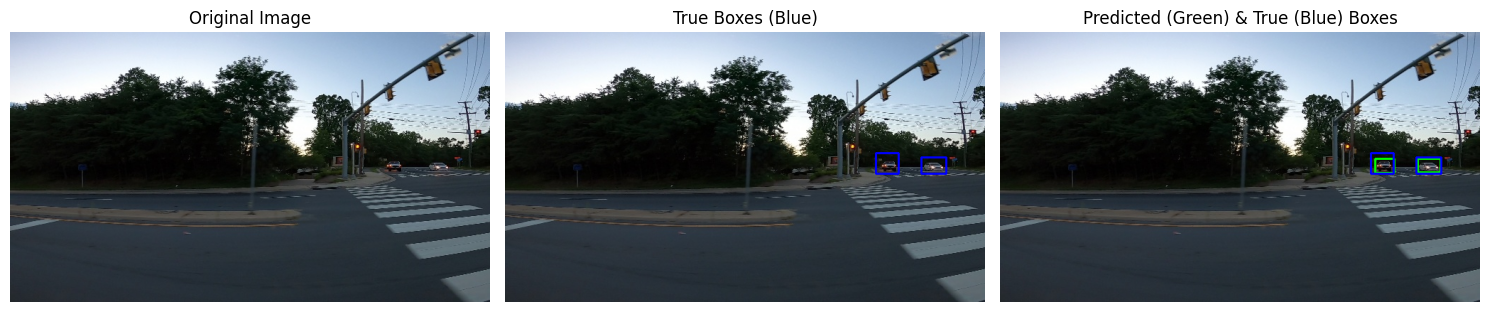


Image: vid_5_27320.jpg
Cars in image: 2
Cars detected: 0

0: 384x640 1 car, 7.6ms
Speed: 1.2ms preprocess, 7.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


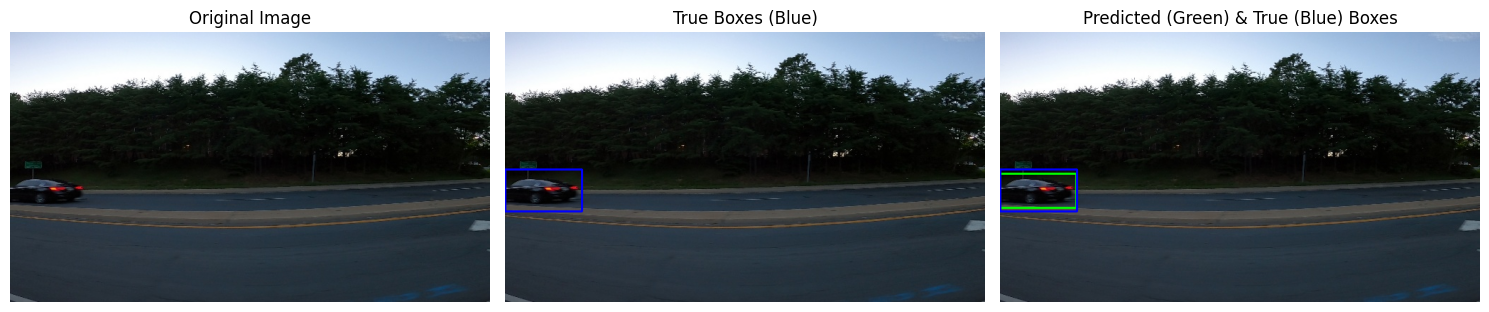


Image: vid_5_27240.jpg
Cars in image: 1
Cars detected: 1

0: 384x640 (no detections), 7.6ms
Speed: 1.3ms preprocess, 7.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


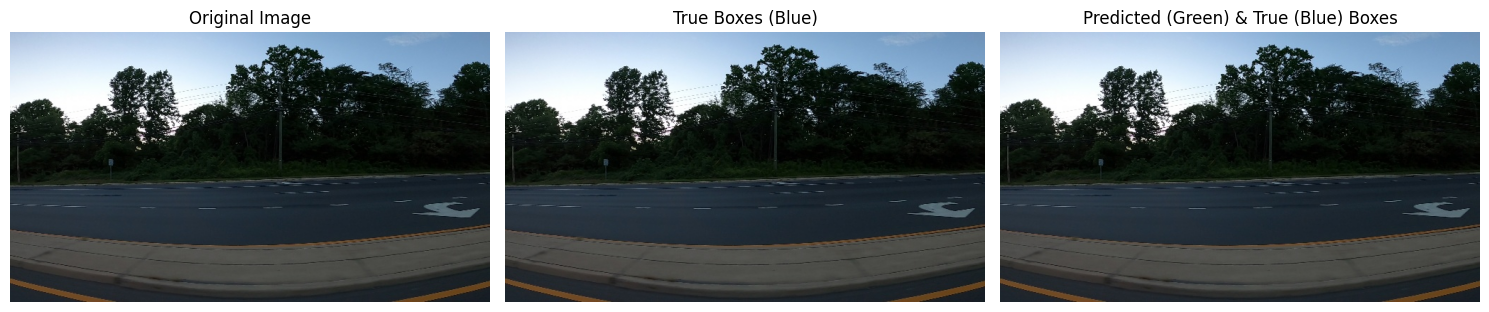


Image: vid_5_27720.jpg
Cars in image: 0
Cars detected: 0

0: 384x640 (no detections), 7.5ms
Speed: 1.3ms preprocess, 7.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


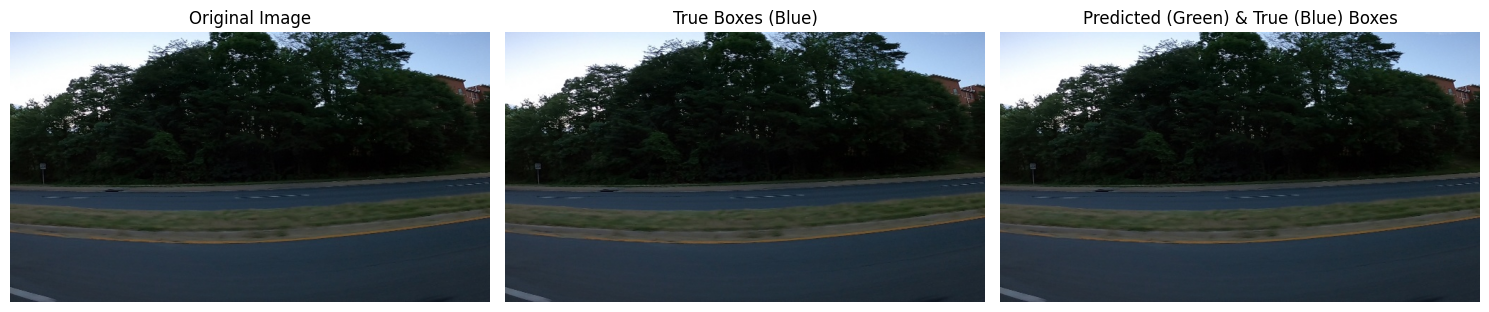


Image: vid_5_26980.jpg
Cars in image: 0
Cars detected: 0

Total Results:
Total cars in all images: 4
Total cars detected: 2
Detection accuracy: 0.50


In [4]:
import os
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

def main():
    # Load YOLO model
    modelPath = './runs/detect/car_detection_20/weights/best.pt'
    imageDir = './Make sense/'
    labelDir = './Make sense labels/'
    model = YOLO(modelPath)

    # Get list of image files
    imageFiles = [file for file in os.listdir(imageDir) if file.lower().endswith(('.png', '.jpg', '.jpeg'))][:5]

    totalCarsAll = 0
    detectedCarsAll = 0

    for imageFile in imageFiles:
        # Paths for image and label files
        imagePath = Path(imageDir) / imageFile
        labelPath = Path(labelDir) / f"{Path(imageFile).stem}.txt"

        # Load image
        image = cv2.imread(str(imagePath))
        originalImage = image.copy()
        trueBoxesImage = image.copy()
        bothBoxesImage = image.copy()

        # Load true boxes
        trueBoxes = []
        if labelPath.is_file():
            with open(labelPath, 'r') as lp:
                for line in lp:
                    classId, x, y, w, h = map(float, line.strip().split())
                    imageHeight, imageWidth = image.shape[:2]
                    x1, y1 = int((x - w / 2) * imageWidth), int((y - h / 2) * imageHeight)
                    x2, y2 = int((x + w / 2) * imageWidth), int((y + h / 2) * imageHeight)
                    trueBoxes.append([x1, y1, x2, y2])
                    cv2.rectangle(trueBoxesImage, (x1, y1), (x2, y2), (255, 0, 0), 2)

        # Get predictions
        results = model(image)
        predictedBoxes = results[0].boxes.xyxy.cpu().numpy()

        # Draw predicted boxes
        for box in predictedBoxes:
            x1, y1, x2, y2 = map(int, box[:4])
            cv2.rectangle(bothBoxesImage, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Draw true boxes on combined image
        for box in trueBoxes:
            x1, y1, x2, y2 = box
            cv2.rectangle(bothBoxesImage, (x1, y1), (x2, y2), (255, 0, 0), 2)

        # Plot results
        plt.figure(figsize=(15, 5))
        plt.subplot(131)
        plt.imshow(cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(132)
        plt.imshow(cv2.cvtColor(trueBoxesImage, cv2.COLOR_BGR2RGB))
        plt.title('True Boxes (Blue)')
        plt.axis('off')

        plt.subplot(133)
        plt.imshow(cv2.cvtColor(bothBoxesImage, cv2.COLOR_BGR2RGB))
        plt.title('Predicted (Green) & True (Blue) Boxes')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Evaluate predictions directly
        carsIdentified = 0
        totalCars = len(trueBoxes)
        matchedPreds = set()

        for trueBox in trueBoxes:
            bestIoU = 0.5
            bestPredIdx = -1

            for j, predBox in enumerate(predictedBoxes):
                if j in matchedPreds:
                    continue

                # IoU calculation logic
                b1 = predBox
                b2 = [trueBox[0] - 5, trueBox[1] - 5, 
                      trueBox[2] + 5, trueBox[3] + 5]

                interX1 = max(b1[0], b2[0])
                interY1 = max(b1[1], b2[1])
                interX2 = min(b1[2], b2[2])
                interY2 = min(b1[3], b2[3])

                interArea = max(0, interX2 - interX1) * max(0, interY2 - interY1)
                predArea = (b1[2] - b1[0]) * (b1[3] - b1[1])
                trueArea = (b2[2] - b2[0]) * (b2[3] - b2[1])

                iou = interArea / float(predArea + trueArea - interArea)

                if iou > bestIoU:
                    bestIoU = iou
                    bestPredIdx = j

            if bestPredIdx >= 0:
                carsIdentified += 1
                matchedPreds.add(bestPredIdx)

        # Accumulate results
        totalCarsAll += totalCars
        detectedCarsAll += carsIdentified

        print(f"\nImage: {imageFile}")
        print(f"Cars in image: {totalCars}")
        print(f"Cars detected: {carsIdentified}")

    # Final results
    print(f"\nTotal Results:")
    print(f"Total cars in all images: {totalCarsAll}")
    print(f"Total cars detected: {detectedCarsAll}")
    print(f"Detection accuracy: {detectedCarsAll / totalCarsAll:.2f}")

if __name__ == "__main__":
    main()
